# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [89]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [125]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# lets see shape of both datasets
print (azdias.shape)
print (feat_info.shape)

(891221, 85)
(85, 4)


In [126]:
# view first few rows of Demographics data
azdias.head(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [127]:
# lets view some stats
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [128]:
#view structure of demographics data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [129]:
# view demographic data info from feature summary file
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [130]:
# Identify missing or unknown data values and convert them to NaNs.

# show naturally missing values
print('Total no of naturally missing values is {}'.format(azdias.isnull().sum().sum()))

Total no of naturally missing values is 4896838


In [131]:
# show column wise naturally missing values
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [132]:
df = azdias.CAMEO_DEU_2015 == 'XX'
df.sum()

373

In [90]:
#feature summary file column missing_or_unknown contains all values are should be considered as missing values on data , 
#for example for feature "AGER_TYP" missing values are [-1,0].
#we need to convert missing_or_unknown to list and compare data values of corrosponing columns in data and assign to nan

for feature in azdias.columns:
    # get corrosponding feature info
    feature_info = feat_info[feat_info.attribute == feature] #get corrospoing feature info
    nan_lst_values = feature_info["missing_or_unknown"].iloc[0][1:-1].split(",") # get nan values for that column
    azdias.loc[azdias[feature].isin(nan_lst_values), feature] = np.nan # update all nan values from list to np.nan

azdias.head() #review first 5 rows

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [91]:
#review total is null values again
print('Total no of missing values is {}'.format(azdias.isnull().sum().sum()))

Total no of missing values is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [92]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# get percent missing values in each features
percent_missing_values = (azdias.isnull().sum()/azdias.shape[0]) * 100
percent_missing_values

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

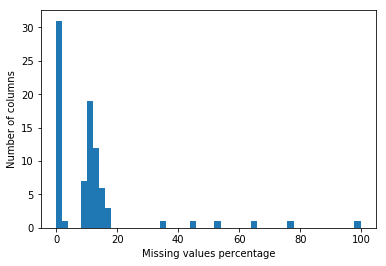

In [93]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percent_missing_values, bins=50)
plt.ylabel('Number of columns')
plt.xlabel('Missing values percentage')
plt.show()


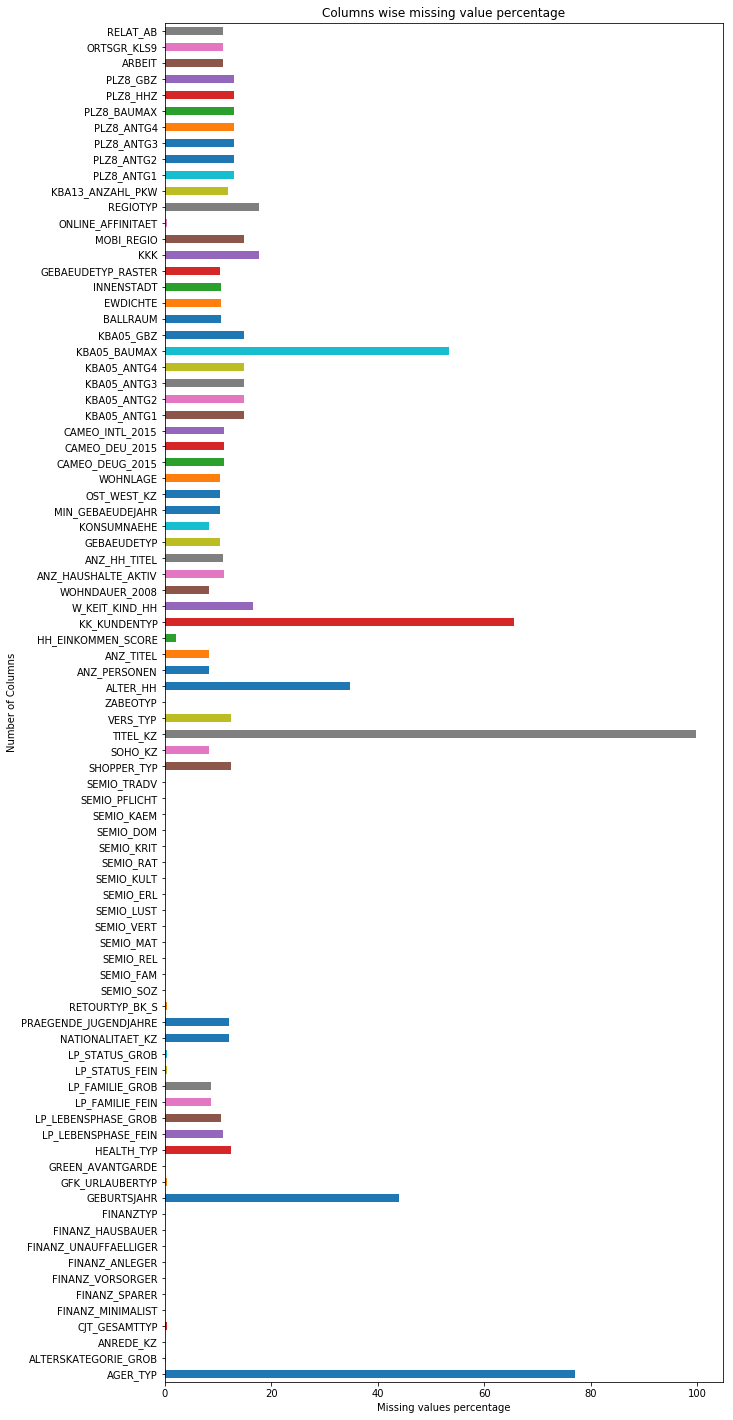

In [94]:
percent_missing_values.plot(kind="barh", figsize = (10,25))
plt.ylabel('Number of Columns')
plt.xlabel('Missing values percentage')
plt.title("Columns wise missing value percentage")
plt.show()

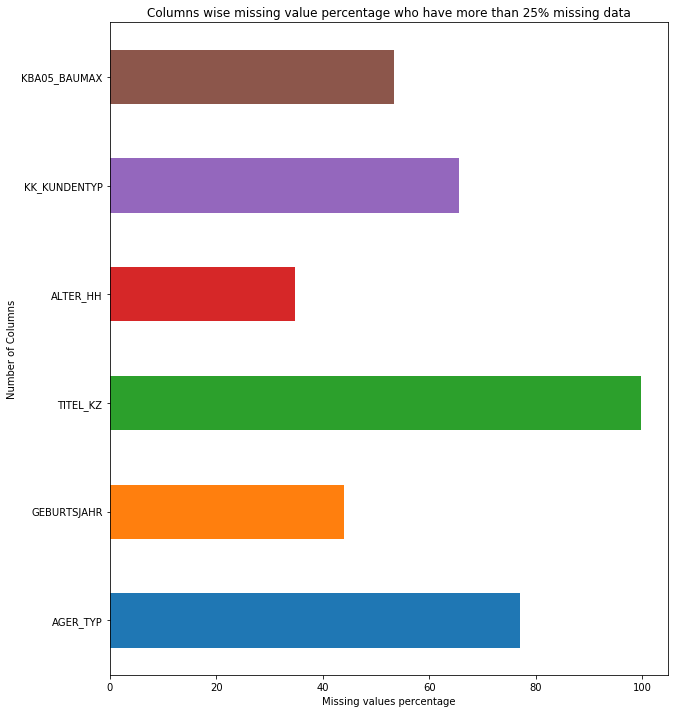

In [95]:
#columns with more than 25% of missing data
df25 = percent_missing_values[percent_missing_values > 25]
df25.plot(kind="barh", figsize = (10,12))
plt.ylabel('Number of Columns')
plt.xlabel('Missing values percentage')
plt.title("Columns wise missing value percentage who have more than 25% missing data")
plt.show()

In [96]:
#print values to see actual missing percentage
df25

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [97]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
#Looking at above seems like columns (AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX) 
#have more than 34% of missing datawill remove these columns
columns_to_drop = df25.index.tolist()
columns_to_drop

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [98]:
#remove above columns
azdias.drop(columns_to_drop, axis=1, inplace = True)
azdias.info() #confirm if they are removed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
FINANZTYP                891221 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STAT

#### Discussion 1.1.2: Assess Missing Data in Each Column

Most of the features have less than 25% of missing data , these are the six columns who have have missing data in range from 34 to 99 percent. These(AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX) are the columns we removed from data set.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [99]:
# How much data is missing in each row of the dataset?
row_wise_missing_data = azdias.isnull().sum (axis = 1)
row_wise_missing_data.head()


0    43
1     0
2     0
3     7
4     0
dtype: int64

In [100]:
# lets get no of rows having missing data
num_rows_having_missing_data = row_wise_missing_data[row_wise_missing_data>0]
num_rows_having_missing_data.describe()

count    268012.000000
mean         18.787607
std          18.320049
min           1.000000
25%           4.000000
50%           8.000000
75%          43.000000
max          49.000000
dtype: float64

#this shows out of out of 891221 rows 628074 rows have missing data. 

Text(0,0.5,'number of rows')

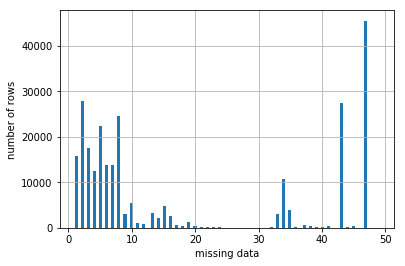

In [101]:
#plot graph
num_rows_having_missing_data.hist(bins=100)
plt.xlabel("missing data")
plt.ylabel("number of rows")

In [102]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# add a column in our dataset conatisn no of missing rows per rows

azdias["row_wise_missing_data"] = azdias.isnull().sum (axis = 1)
azdias["row_wise_missing_data"].head() 

0    43
1     0
2     0
3     7
4     0
Name: row_wise_missing_data, dtype: int64

In [103]:
# Create two datasets based on misisng columns

#looking at graph looks like we can divide our data into two for rows who have missing values in each row > 20
azdias_missing_data = azdias[azdias.row_wise_missing_data > 0 ].copy()
azdias_no_missing_data = azdias[azdias.row_wise_missing_data == 0].copy()

In [104]:
#display these data sets to see details
display(azdias_no_missing_data.describe())
display(azdias_missing_data.describe())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_wise_missing_data
count,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,...,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.000000,623209.0
mean,2.792540,1.511211,3.470625,3.057793,2.677015,3.451430,2.770220,2.563095,3.169596,3.914579,...,2.832587,1.631794,0.718529,1.985612,3.614714,3.350438,3.199007,5.394508,3.113073,0.0
std,1.026485,0.499875,1.521561,1.360774,1.469261,1.388873,1.448796,1.372308,1.365483,2.082482,...,0.917406,0.984108,0.731720,1.476932,0.960938,1.113337,0.989195,2.295721,1.351074,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
25%,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,...,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000,0.0
50%,3.000000,2.000000,4.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,5.000000,...,3.000000,2.000000,1.000000,1.000000,3.000000,3.000000,3.000000,5.000000,3.000000,0.0
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,6.000000,...,4.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000,0.0
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000,0.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_wise_missing_data
count,265131.000000,268012.000000,263158.000000,268012.000000,268012.000000,268012.000000,268012.000000,268012.000000,268012.000000,268012.000000,...,151497.000000,151497.000000,151497.000000,151497.000000,151497.000000,151497.000000,170637.000000,170738.000000,170637.000000,268012.000000
mean,2.674187,1.547416,4.016990,3.113443,3.155937,3.284088,3.645135,3.597503,2.855436,3.502265,...,2.675446,1.445817,0.619511,1.772378,3.605035,3.507165,3.048641,4.924293,2.917492,18.787607
std,0.964900,0.497748,1.695996,1.222840,1.397971,1.143568,1.537547,1.490924,1.298046,1.713872,...,0.921444,0.983432,0.702379,1.373061,1.025790,1.095437,1.025731,2.293595,1.383728,18.320049
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,3.000000,2.000000,4.000000
50%,3.000000,2.000000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,...,3.000000,1.000000,0.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000,8.000000
75%,3.000000,2.000000,6.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,...,3.000000,2.000000,1.000000,2.000000,4.000000,4.000000,4.000000,7.000000,4.000000,43.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000,49.000000


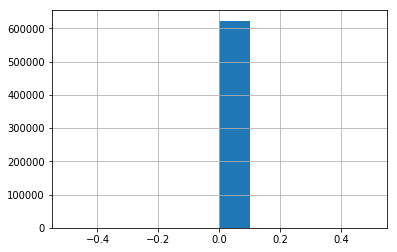

In [148]:
# plot these datasets
azdias_no_missing_data["row_wise_missing_data"].hist()


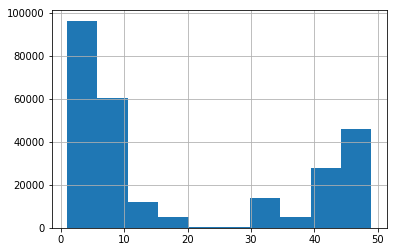

In [149]:
azdias_missing_data["row_wise_missing_data"].hist()

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#create common function for plot comparision
def plot (ds1, ds2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    sns.countplot(ds1, ax=ax1)
    ax1.set_title(title1);
    sns.countplot(ds2, ax=ax2)
    ax2.set_title(title2);
    f.subplots_adjust(wspace=.7)
    return

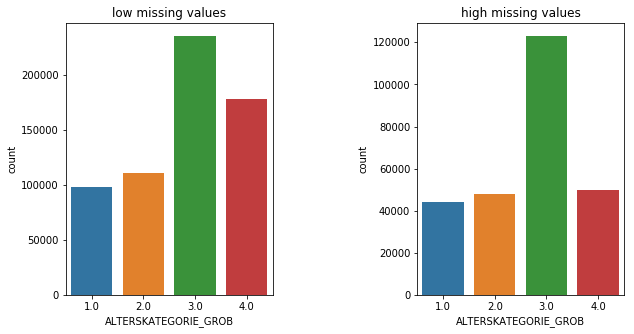

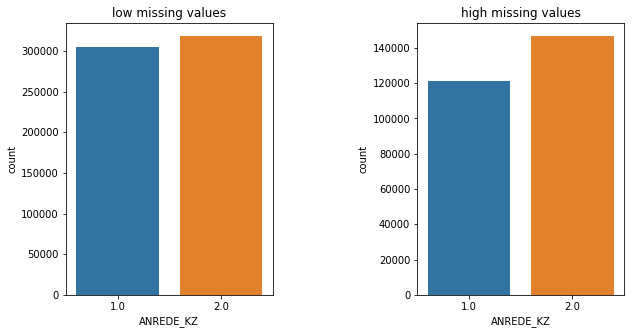

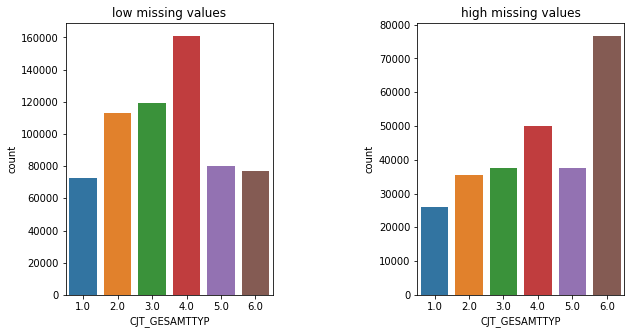

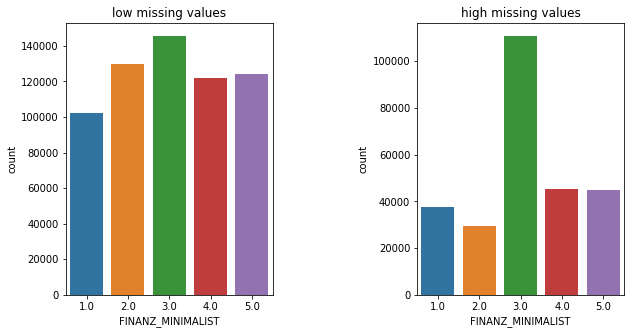

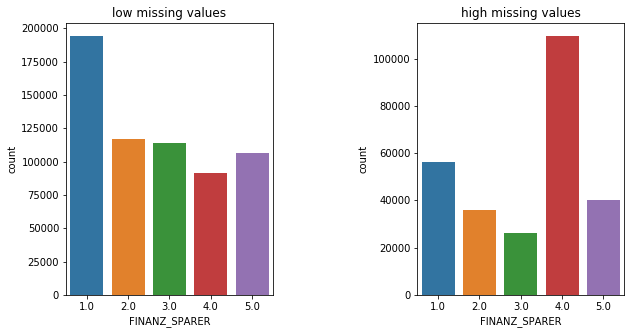

In [108]:
# plot 5 columns
for column in azdias.columns[0:5]:
    plot(azdias_no_missing_data[column], azdias_missing_data[column], "low missing values", "high missing values")

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Looking at plots above looks like that other than "ANDRE_KZ" feature other columns values are quite diff.
from here on I will be using azdias_no_missing_data dataset further.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [152]:
# How many features are there of each data type?
#feature info in original dataset
feat_info["type"].value_counts ()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [153]:
#since we have removed certain columns we need to remove it from fetaure info dataset as well
feat_info = feat_info[feat_info.attribute.isin(azdias.columns)]
feat_info["type"].value_counts ()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [154]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_variable_info = feat_info[feat_info.type == "categorical"]
categorical_variable_info

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [155]:
#see num values of these fetures to identify binray and multi-level
categorical_features = azdias_no_missing_data[categorical_variable_info.attribute].nunique(axis = 0)
categorical_features

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          4
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [156]:
#get binary features
binary_features = categorical_features[categorical_features == 2]
binary_features

ANREDE_KZ           2
GREEN_AVANTGARDE    2
SOHO_KZ             2
VERS_TYP            2
OST_WEST_KZ         2
dtype: int64

In [157]:
multi_level_features = categorical_features[categorical_features > 2]
multi_level_features

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          4
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [158]:
# Re-encode categorical variable(s) to be kept in the analysis.
#lets view binary values
for feature in binary_features.index.values:
    print("unique values for {0}, {1}".format(feature, azdias_no_missing_data[feature].unique()))

unique values for ANREDE_KZ, [ 2.  1.]
unique values for GREEN_AVANTGARDE, [ 0.  1.]
unique values for SOHO_KZ, [ 1.  0.]
unique values for VERS_TYP, [ 2.  1.]
unique values for OST_WEST_KZ, ['W' 'O']


In [159]:
#feature OST_WEST_KZ has non numeric values we need to convert these values to numeric
azdias_no_missing_data["OST_WEST_KZ"] = azdias_no_missing_data["OST_WEST_KZ"].map({'W': 0, 'O': 1})

In [160]:
#lets view multi_level values
for feature in multi_level_features.index.values:
    print("unique values for {0}, {1}".format(feature, azdias_no_missing_data[feature].unique()))

unique values for CJT_GESAMTTYP, [ 5.  3.  2.  4.  1.  6.]
unique values for FINANZTYP, [ 1.  5.  2.  4.  6.  3.]
unique values for GFK_URLAUBERTYP, [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   6.   2.]
unique values for LP_FAMILIE_FEIN, [  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.]
unique values for LP_FAMILIE_GROB, [ 3.  1.  5.  2.  4.]
unique values for LP_STATUS_FEIN, [  2.   3.   4.   1.  10.   9.   5.   6.   7.   8.]
unique values for LP_STATUS_GROB, [ 1.  2.  5.  4.  3.]
unique values for NATIONALITAET_KZ, [ 1.  2.  3.]
unique values for SHOPPER_TYP, [ 3.  2.  0.  1.]
unique values for ZABEOTYP, [ 5.  4.  1.  6.  3.  2.]
unique values for GEBAEUDETYP, [ 8.  1.  3.  5.]
unique values for CAMEO_DEUG_2015, ['8' '4' '6' '2' '1' '9' '5' '7' '3']
unique values for CAMEO_DEU_2015, ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '1B' '8B' '7A'
 '3D' '4E' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '5C' '9C' '7D' '5E' '1D' '8D'
 '6C' '5B' '7C' '4D' '3A' '2B' '7E' '

In [161]:
# lets drop multi_level_features for this analysis
for feature in multi_level_features.index.values:
    azdias_no_missing_data.drop(feature, axis=1, inplace = True)

In [162]:

azdias_no_missing_data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
PRAEGENDE_JUGENDJAHRE    623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null float64
SEMIO_FAM                623209 non-null float64
SEMIO_REL                623209 non-null float64
SEMIO_MAT                623209 non-null float64
SEMIO_V

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

So there are 5 binary and 13 multi-level fetures. on those i did following
1. Keep all binary fetures
2. Re-encoded "OST_WEST_KZ" feature as numeric values
2. Dropped all multi-level feature 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [163]:
mixed_variable_info = feat_info[feat_info.type == "mixed"]
mixed_variable_info

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [164]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_no_missing_data['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   5.,   4.,   2.,   6.,
         1.,  12.,  13.,   7.])

In [165]:
#read Data_Dictionary file to get more info
myfile = open("Data_Dictionary.md")
txt = myfile.read()
print(txt)
myfile.close()

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [166]:
#add two columns decade and movement
azdias_no_missing_data["PRAEGENDE_JUGENDJAHRE_DECADE"] = azdias_no_missing_data["PRAEGENDE_JUGENDJAHRE"]
azdias_no_missing_data["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = azdias_no_missing_data["PRAEGENDE_JUGENDJAHRE"]

In [167]:
# create dictinonary object to map values
decade =  {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1,15:0}

#map columns with dict
azdias_no_missing_data['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade, inplace=True)
azdias_no_missing_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement, inplace=True)


In [168]:
display(azdias_no_missing_data['PRAEGENDE_JUGENDJAHRE_DECADE'].unique())
display(azdias_no_missing_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].unique())

array([ 6.,  4.,  2.,  5.,  3.,  1.])

array([ 1.,  0.])

In [169]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_no_missing_data['CAMEO_INTL_2015'].unique()

array(['51', '24', '43', '54', '22', '14', '13', '15', '34', '55', '41',
       '25', '31', '52', '45', '35', '33', '44', '32', '23', '12'], dtype=object)

In [170]:
# Add two columns wealth and life_stage
azdias_no_missing_data['CAMEO_INTL_2015_WEALTH'] = azdias_no_missing_data['CAMEO_INTL_2015']
azdias_no_missing_data['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_no_missing_data['CAMEO_INTL_2015']

In [171]:
# create dictinonary object to map values
wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

#map columns with dict
azdias_no_missing_data['CAMEO_INTL_2015_WEALTH'].replace(wealth, inplace=True)
azdias_no_missing_data['CAMEO_INTL_2015_LIFE_STAGE'].replace(life_stage, inplace=True)

In [172]:
display(azdias_no_missing_data['PRAEGENDE_JUGENDJAHRE_DECADE'].unique())
display(azdias_no_missing_data['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].unique())

array([ 6.,  4.,  2.,  5.,  3.,  1.])

array([ 1.,  0.])

In [173]:
mixed_variable_info["attribute"]

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I used (PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015) to create new features and droped other mixed fectaures

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [174]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#alreday done

In [175]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
for feature in mixed_variable_info["attribute"]:
    azdias_no_missing_data.drop(feature, axis=1, inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [4]:
def clean_data(df, df_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    #feature summary file column missing_or_unknown contains all values are should be considered as missing values on data , 
    #for example for feature "AGER_TYP" missing values are [-1,0].
    #we need to convert missing_or_unknown to list and compare data values of corrosponing columns in data and assign to nan

    for feature in df.columns:
        # get corrosponding feature info
        feature_info = df_info[df_info.attribute == feature] #get corrospoing feature info
        nan_lst_values = feature_info["missing_or_unknown"].iloc[0][1:-1].split(",") # get nan values for that column
        df.loc[df[feature].isin(nan_lst_values), feature] = np.nan # update all nan values from list to np.nan

    
    # remove selected columns and rows, ...
    columns_to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(columns_to_drop, axis=1)
    
    # remove info from feature info dataset too
    df_info = df_info[df_info.attribute.isin(df.columns)]
    
    #clean dataset to get rows with no missing values
    df["row_wise_missing_data"] = df.isnull().sum (axis = 1)
    df_clean = df[df["row_wise_missing_data"] == 0].copy()
    
    categorical_variable_info = df_info[df_info.type == "categorical"]
    categorical_features = df_clean[categorical_variable_info.attribute].nunique(axis = 0)
    multi_level_features = categorical_features[categorical_features > 2]
    mixed_variable_info = df_info[df_info.type == "mixed"]
    
    #feature OST_WEST_KZ has non numeric values we need to convert these values to numeric
    df_clean["OST_WEST_KZ"] = df_clean["OST_WEST_KZ"].map({'W': 0, 'O': 1})
    
    # lets drop multi_level_features for this analysis
    for feature in multi_level_features.index.values:
        df_clean.drop(feature, axis=1, inplace = True)
    
    # handle mixed type
    # add two columns decade and movement
    df_clean["PRAEGENDE_JUGENDJAHRE_DECADE"] = df_clean["PRAEGENDE_JUGENDJAHRE"]
    df_clean["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = df_clean["PRAEGENDE_JUGENDJAHRE"]
                                            
    # create dictinonary object to map values
    decade =  {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1,15:0}

    # map columns with dict
    df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade, inplace=True)
    df_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement, inplace=True)
   
    # Add two columns wealth and life_stage
    df_clean['CAMEO_INTL_2015_WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['CAMEO_INTL_2015_LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']  
                                            
    # create dictinonary object to map values
    wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

    #map columns with dict
    df_clean['CAMEO_INTL_2015_WEALTH'].replace(wealth, inplace=True)
    df_clean['CAMEO_INTL_2015_LIFE_STAGE'].replace(life_stage, inplace=True)  
    
    #drop mixed type columns                                        
    for feature in mixed_variable_info["attribute"]:
        df_clean.drop(feature, axis=1, inplace=True)  
        
    #lets also remove row_wise_missing_data column that we added
    df_clean.drop("row_wise_missing_data", axis=1, inplace=True)  
    
    return df_clean, df_info
    

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [6]:
df, df_info = clean_data(azdias, feat_info)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB              623209 non-null float64
ANREDE_KZ                         623209 non-null float64
FINANZ_MINIMALIST                 623209 non-null float64
FINANZ_SPARER                     623209 non-null float64
FINANZ_VORSORGER                  623209 non-null float64
FINANZ_ANLEGER                    623209 non-null float64
FINANZ_UNAUFFAELLIGER             623209 non-null float64
FINANZ_HAUSBAUER                  623209 non-null float64
GREEN_AVANTGARDE                  623209 non-null float64
HEALTH_TYP                        623209 non-null float64
RETOURTYP_BK_S                    623209 non-null float64
SEMIO_SOZ                         623209 non-null float64
SEMIO_FAM                         623209 non-null float64
SEMIO_REL                         623209 non-null float64
SEMIO_MAT                         623209 non-null float64
SEMIO_VERT         

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [8]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

df.isna().sum().sum()

0

In [10]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,0.384670,1.441599,0.583438,-0.201181,-0.171845,0.656462,1.164454,0.553670,1.147882,-1.251108
1,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.981973,0.400949,0.583438,-0.201181,-0.171845,-0.823844,1.164454,-1.806129,-0.909997,0.749822
2,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,0.384670,-0.639702,-0.314764,0.809743,0.263748,1.396614,-0.213400,0.553670,0.461922,0.082845
3,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,0.384670,1.441599,1.481640,-1.212105,-1.043032,-0.083691,-1.591253,0.553670,1.147882,0.749822
4,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,-0.981973,1.441599,1.481640,0.809743,0.263748,-0.083691,0.475527,0.553670,-0.909997,-0.584131


### Discussion 2.1: Apply Feature Scaling

I used StandardScaler to get the data to same scale. this Standardize features by removing the mean and scaling to unit variance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [36]:
# from udacity function to plot
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [11]:
# Apply PCA to the data.
pca = PCA()
pca.fit_transform(df) 

array([[  4.08960037e+00,  -2.25071576e+00,  -2.95874235e+00, ...,
          2.04425237e-01,   1.24944765e-01,   9.63218634e-13],
       [ -1.05294212e+00,   4.39904256e-02,  -3.09669166e+00, ...,
          5.29835948e-02,  -5.57985863e-02,   2.96281277e-13],
       [  4.46213445e-01,   2.01861422e-01,   3.20281742e+00, ...,
          4.88466736e-01,   3.46303549e-01,   1.10926486e-13],
       ..., 
       [  3.62283687e+00,  -1.63829630e+00,  -3.63674348e+00, ...,
          6.00881855e-01,  -1.69281793e-01,   2.73758957e-16],
       [  6.14665058e+00,  -2.70792010e+00,   2.18404897e+00, ...,
          4.15826156e-01,  -1.53190580e-01,  -6.14276723e-16],
       [ -8.50461301e-01,   8.82622096e-01,   2.93669434e+00, ...,
          7.54488829e-01,   2.43873630e-01,  -5.09558283e-16]])

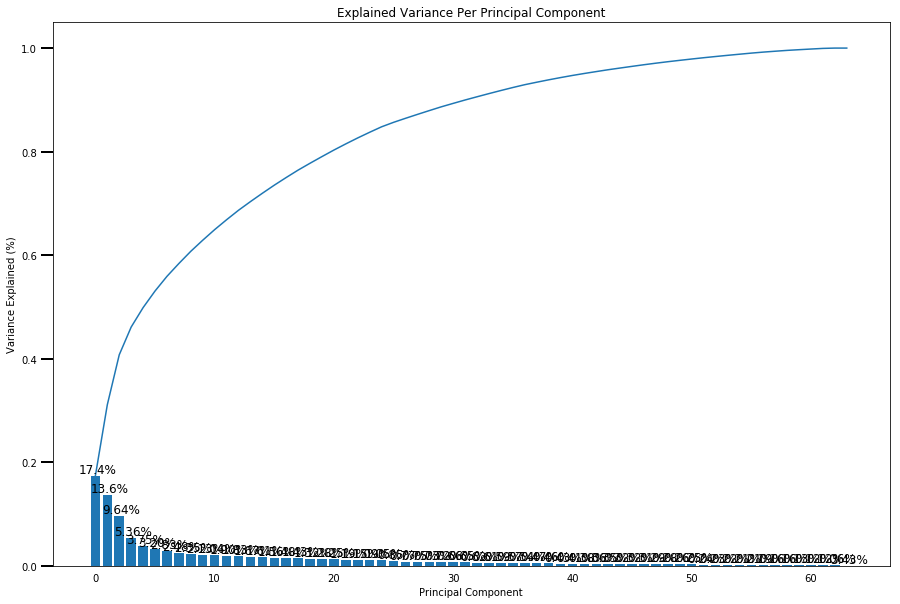

In [38]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)


In [12]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_components = PCA(20)
pca_dt = pca_components.fit_transform(df)  
pca_components.explained_variance_ratio_.sum()

0.79035006733946089

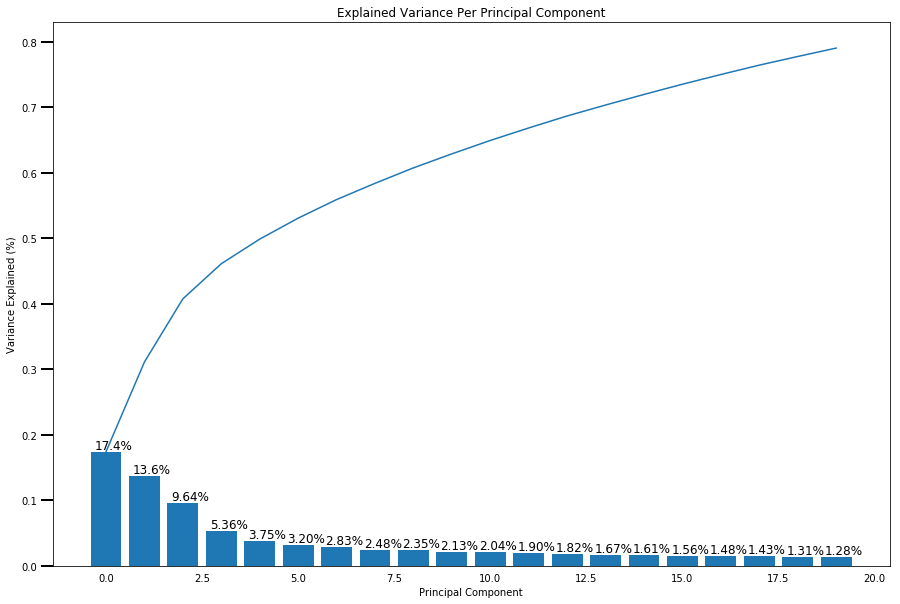

In [53]:
scree_plot(pca_components)

### Discussion 2.2: Perform Dimensionality Reduction
Applied the pca and after reviewing plot, decided to retain 20 components which gives around 79% of variance. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [13]:
df_components = pd.DataFrame (pca_components.components_, columns = list(df.columns))
df_components.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-0.147905,-0.003882,-0.222483,0.165814,-0.136351,0.087291,0.094741,0.144909,-0.115301,0.038563,...,0.207551,0.035648,-0.162744,0.137235,0.184226,0.124980,0.126725,0.115301,0.197155,-0.125976
1,0.245188,0.090215,0.040815,-0.217398,0.213828,-0.193506,-0.216888,0.130939,-0.030863,-0.048853,...,0.112917,0.014866,-0.092383,0.083185,0.110599,0.077828,-0.236761,0.030863,0.092701,-0.017051
2,0.082353,-0.367635,0.156671,-0.101301,0.098248,-0.188285,-0.092779,-0.047401,0.050847,-0.010783,...,0.046400,0.006606,-0.037478,0.033022,0.048823,0.031364,-0.107610,-0.050847,0.024853,-0.009342
3,-0.042270,0.042767,0.058343,-0.000438,-0.019889,-0.128432,0.088781,-0.101835,0.391565,0.003368,...,0.085571,0.129160,0.022810,0.050955,0.250309,0.093399,0.040799,-0.391565,-0.130852,0.061187
4,-0.002321,-0.006189,-0.083359,-0.000060,0.059692,-0.048861,0.042755,0.086214,-0.057612,-0.009302,...,-0.015607,0.495551,0.397790,-0.206565,-0.089262,-0.139511,-0.032329,0.057612,0.007844,-0.027210


In [43]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_pca_weights(df, component):
    print("top 5 positive values")
    display(df.iloc[component].sort_values(ascending=False)[:5])
    print('top 5 negative weights')
    display(df.iloc[component].sort_values(ascending=True)[:5])
    
    
print_pca_weights(df_components, 0)   

top 5 positive values


PLZ8_ANTG3                0.213717
PLZ8_ANTG4                0.207551
CAMEO_INTL_2015_WEALTH    0.197155
HH_EINKOMMEN_SCORE        0.195056
ORTSGR_KLS9               0.184226
Name: 0, dtype: float64

top 5 negative weights


MOBI_REGIO          -0.233061
FINANZ_MINIMALIST   -0.222483
KBA05_ANTG1         -0.218352
PLZ8_ANTG1          -0.215424
KBA05_GBZ           -0.208101
Name: 0, dtype: float64

In [44]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weights(df_components, 1)


top 5 positive values


ALTERSKATEGORIE_GROB    0.245188
SEMIO_ERL               0.224264
FINANZ_VORSORGER        0.213828
SEMIO_LUST              0.169071
RETOURTYP_BK_S          0.161124
Name: 1, dtype: float64

top 5 negative weights


SEMIO_REL                      -0.251535
PRAEGENDE_JUGENDJAHRE_DECADE   -0.236761
SEMIO_PFLICHT                  -0.225035
SEMIO_TRADV                    -0.218421
FINANZ_SPARER                  -0.217398
Name: 1, dtype: float64

In [45]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weights(df_components, 2)

top 5 positive values


SEMIO_VERT           0.348014
SEMIO_SOZ            0.263596
SEMIO_FAM            0.251414
SEMIO_KULT           0.231457
FINANZ_MINIMALIST    0.156671
Name: 2, dtype: float64

top 5 negative weights


ANREDE_KZ    -0.367635
SEMIO_KAEM   -0.337117
SEMIO_DOM    -0.312720
SEMIO_KRIT   -0.268971
SEMIO_RAT    -0.219058
Name: 2, dtype: float64

### Discussion 2.3: Interpret Principal Components

Component 1 : Tells about relationship between share of family homes in a macro cell links with there welath and movement. There is positive correlation between no of family houses and there wealth so if no of family houses increase that means have more poor family in thet region. There is negative correlation with no of family houses and movement so if no of 10+ or 6-10 family house increase that means high movement.

Component 2: Tells about ralationship between age, personality and financial. There is positive correlation be age, sensual, event orianted, financial preparation and negative relationship with religious affinity, dutiful and tradional-minded. That means that older age people have low financial planning are less sensual, low evenet orianted people.   

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [17]:
#function to calc score
def calc_score(data, cluster):
    kmeans = KMeans(cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [58]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
scores = []
clusters = list(range(1,15))
for cluster in clusters:
    scores.append(calc_score(pca_dt, cluster))

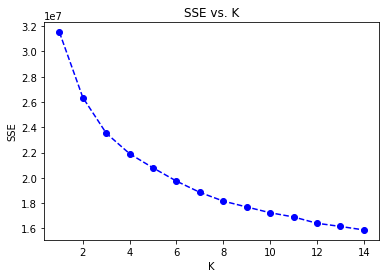

In [59]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.show()

In [19]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(7)
model = kmeans.fit(pca_dt)
pca_dt_predict = model.predict(pca_dt)
np.unique(pca_dt_predict)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

From the plot looks like 6 is at the elbow so i decided to use 6 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [20]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [21]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [12]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [22]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

df_cust, df_cust_info = clean_data(customers, feat_info)

In [23]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115643 entries, 0 to 191651
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB              115643 non-null float64
ANREDE_KZ                         115643 non-null float64
FINANZ_MINIMALIST                 115643 non-null float64
FINANZ_SPARER                     115643 non-null float64
FINANZ_VORSORGER                  115643 non-null float64
FINANZ_ANLEGER                    115643 non-null float64
FINANZ_UNAUFFAELLIGER             115643 non-null float64
FINANZ_HAUSBAUER                  115643 non-null float64
GREEN_AVANTGARDE                  115643 non-null float64
HEALTH_TYP                        115643 non-null float64
RETOURTYP_BK_S                    115643 non-null float64
SEMIO_SOZ                         115643 non-null float64
SEMIO_FAM                         115643 non-null float64
SEMIO_REL                         115643 non-null float64
SEMIO_MAT                         115643 non-null float64
SEMIO_VERT         

In [24]:
# Scale data
scaler = StandardScaler()
df_cust = pd.DataFrame(scaler.fit_transform(df_cust), columns = df_cust.columns)
df_cust.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,0.695345,-0.691442,0.712637,-0.49594,0.492276,-0.574838,0.220190,-0.596238,0.938625,-1.245832,...,-0.851404,1.479191,1.379133,-1.826652,-1.465423,-1.353193,-0.640226,-0.938625,-1.140343,-0.296595
1,0.695345,1.446252,0.712637,-0.49594,0.492276,-0.574838,2.373089,0.952626,0.938625,0.059970,...,0.715440,-0.683186,-1.600931,0.162280,-0.075625,0.055181,-0.640226,-0.938625,0.279880,0.451379
2,-0.781455,-0.691442,-1.281229,-0.49594,-0.727293,2.552022,3.449539,-0.596238,-1.065389,1.365772,...,0.715440,-0.683186,-0.607576,0.162280,-0.075625,-1.353193,0.878059,1.065389,0.989992,-1.792543
3,-0.781455,-0.691442,0.712637,-0.49594,0.492276,-0.574838,0.220190,0.178194,0.938625,1.365772,...,0.715440,1.479191,1.379133,0.162280,0.850907,1.463556,-0.640226,-0.938625,0.279880,0.451379
4,0.695345,-0.691442,0.712637,-0.49594,0.492276,-0.574838,-0.856260,-0.596238,0.938625,0.059970,...,-0.851404,1.479191,1.379133,-0.832186,-1.002157,-0.649006,-0.640226,-0.938625,-0.430232,-0.296595


In [25]:
#PCA
pca_cust_dt = pca_components.fit_transform(df_cust)  
pca_components.explained_variance_ratio_.sum()

0.75843338708310215

In [26]:
#perform clustering
pca_cust_predict = model.predict(pca_cust_dt)
np.unique(pca_cust_predict)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

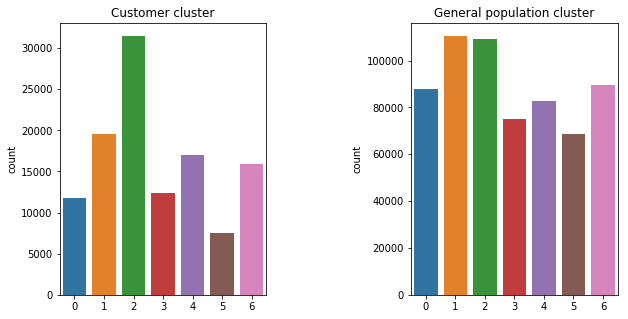

In [27]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
plot(pca_cust_predict, pca_dt_predict, "Customer cluster", "General population cluster")

In [28]:
# get proportion
cust_predict_series = pd.Series(pca_cust_predict).value_counts().sort_index() * 100/len(pca_cust_predict)
general_predict_series = pd.Series(pca_dt_predict).value_counts().sort_index() * 100/len(pca_dt_predict)

In [29]:
cust_predict_series

0    10.177010
1    16.959090
2    27.230355
3    10.664718
4    14.758351
5     6.483747
6    13.726728
dtype: float64

In [30]:
general_predict_series

0    14.064463
1    17.732254
2    17.504080
3    12.069145
4    13.276926
5    10.991016
6    14.362116
dtype: float64

In [31]:
df_proportion = pd.DataFrame({'customer cluser': cust_predict_series,'general population cluster':general_predict_series})
df_proportion

,customer cluser,general population cluster
0,10.177010,14.064463
1,16.959090,17.732254
2,27.230355,17.504080
3,10.664718,12.069145
4,14.758351,13.276926
5,6.483747,10.991016
6,13.726728,14.362116


Text(0,0.5,'Percent')

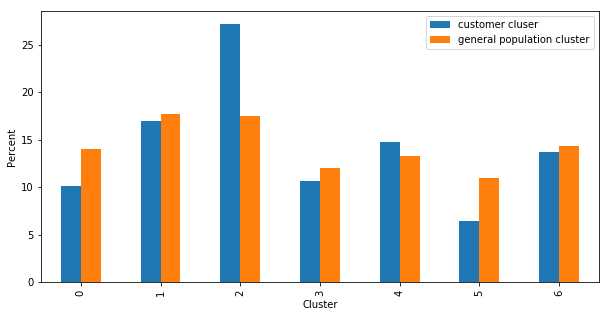

In [32]:
df_proportion.plot(kind="bar", figsize = (10,5))
plt.xlabel("Cluster")
plt.ylabel("Percent")

In [57]:
cluster_info = pd.DataFrame(scaler.inverse_transform(pca_components.inverse_transform(kmeans.cluster_centers_)), columns=df_cust.columns)
cluster_info

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,2.828092,1.159165,3.682424,2.098260,3.905459,1.927714,2.335720,2.855199,0.496690,2.289022,...,0.888228,3.739711,3.208363,3.354921,6.449135,3.642498,3.788076,0.503310,3.230060,3.057036
1,3.100068,1.169843,4.819552,1.876124,4.054200,2.179721,2.258201,1.556582,0.642085,2.175434,...,0.054541,3.437443,4.112416,2.320933,3.556907,2.125866,3.780110,0.357915,1.743387,3.537841
2,4.017371,0.900110,5.362921,0.800792,5.148508,0.895051,1.449385,2.029622,0.798286,1.605734,...,0.180689,3.514952,4.027975,2.439681,4.181551,2.356242,2.022898,0.201714,1.659987,3.995061
3,4.118416,1.756226,3.599910,0.721001,5.337679,1.032770,1.024048,4.432165,0.278780,1.737542,...,0.948081,3.797348,3.174507,3.320707,6.273373,3.603820,1.651422,0.721220,3.768541,2.933323
4,3.859033,1.896557,4.470481,1.199024,4.780037,1.916831,1.651124,2.608038,0.481620,1.873406,...,0.119371,3.527371,4.107597,2.273719,3.573230,2.122322,2.747391,0.518380,1.996313,3.604985
5,2.975893,1.943490,2.953847,2.182724,3.862585,2.528218,2.314803,3.523041,0.151590,2.443533,...,0.893245,3.651343,3.155851,2.988898,5.794082,3.169791,3.982924,0.848410,3.442499,2.935268
6,3.772896,0.821911,4.325214,0.987103,5.037153,0.559212,1.501827,3.262366,0.653982,1.659723,...,1.035417,3.851473,3.138521,3.447831,7.137743,3.862899,1.981329,0.346018,3.158301,3.374516


In [50]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#cluster 2 is overrepresented in the customer data compared to the general population.
print_pca_weights(cluster_detail, 2)

top 5 positive values


FINANZ_MINIMALIST       1.074445
SEMIO_VERT              0.941402
MOBI_REGIO              0.752268
KBA05_ANTG1             0.744064
ALTERSKATEGORIE_GROB    0.720998
Name: 2, dtype: float64

top 5 negative weights


SEMIO_KAEM           -0.996232
SEMIO_DOM            -0.937050
ANREDE_KZ            -0.904977
SEMIO_KRIT           -0.809767
HH_EINKOMMEN_SCORE   -0.761261
Name: 2, dtype: float64

In [61]:
cluster_info.iloc[2]

ALTERSKATEGORIE_GROB                 4.017371
ANREDE_KZ                            0.900110
FINANZ_MINIMALIST                    5.362921
FINANZ_SPARER                        0.800792
FINANZ_VORSORGER                     5.148508
FINANZ_ANLEGER                       0.895051
FINANZ_UNAUFFAELLIGER                1.449385
FINANZ_HAUSBAUER                     2.029622
GREEN_AVANTGARDE                     0.798286
HEALTH_TYP                           1.605734
RETOURTYP_BK_S                       4.180239
SEMIO_SOZ                            5.106711
SEMIO_FAM                            4.542750
SEMIO_REL                            3.354356
SEMIO_MAT                            3.537894
SEMIO_VERT                           6.821234
SEMIO_LUST                           6.498471
SEMIO_ERL                            4.152135
SEMIO_KULT                           4.821346
SEMIO_RAT                            1.795427
SEMIO_KRIT                           2.432739
SEMIO_DOM                         

In [63]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#cluster 5 is underrepresented in the customer data compared to the general population.
print_pca_weights(cluster_detail, 5)

top 5 positive values


MIN_GEBAEUDEJAHR       1992.414095
KBA13_ANZAHL_PKW        605.590663
ANZ_HAUSHALTE_AKTIV      11.517910
WOHNDAUER_2008            8.236251
SEMIO_ERL                 6.193834
Name: 5, dtype: float64

top 5 negative weights


ANZ_TITEL          -0.039750
SOHO_KZ             0.003252
ANZ_HH_TITEL        0.033811
OST_WEST_KZ         0.132744
GREEN_AVANTGARDE    0.151590
Name: 5, dtype: float64

In [60]:
cluster_info.iloc[5]

ALTERSKATEGORIE_GROB                 2.975893
ANREDE_KZ                            1.943490
FINANZ_MINIMALIST                    2.953847
FINANZ_SPARER                        2.182724
FINANZ_VORSORGER                     3.862585
FINANZ_ANLEGER                       2.528218
FINANZ_UNAUFFAELLIGER                2.314803
FINANZ_HAUSBAUER                     3.523041
GREEN_AVANTGARDE                     0.151590
HEALTH_TYP                           2.443533
RETOURTYP_BK_S                       3.466315
SEMIO_SOZ                            3.375134
SEMIO_FAM                            2.610918
SEMIO_REL                            2.558137
SEMIO_MAT                            2.539697
SEMIO_VERT                           2.848840
SEMIO_LUST                           4.555944
SEMIO_ERL                            6.193834
SEMIO_KULT                           2.440776
SEMIO_RAT                            3.966019
SEMIO_KRIT                           5.969305
SEMIO_DOM                         

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Cluster 2 is overrepresented in the customers data compared to general population below are the few of properties that are reletively popular with mail-order company
1. There are > 60 years old.
2. Have high Financial intrest
3. Have low movement
4. high share of 1-2 family homes in microcell
5. Are male
6. And have high income

Cluster 5 is underrepresented in the customers data compared to general population below are the few of properties that are reletively unpopular with mail-order company
1. Age group is between 30 - 45 years old
1. Females
2. There dominant-minded topology is very low
3. Have low financial intrest
5. Are not a member of green avantgarde
6. Number of professional academic title holders in household is very low

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

### Refrences

1. https://stackoverflow.com/questions/33990955/combine-pandas-dataframe-query-method-with-isin
2. https://stackoverflow.com/questions/18250298/how-to-check-if-a-value-is-in-the-list-in-selection-from-pandas-data-frame
3. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
4. https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html
5. https://www.geeksforgeeks.org/random-numbers-in-python/
6. https://stackoverflow.com/questions/37365357/when-i-use-matplotlib-in-jupyter-notebook-it-always-raise-matplotlib-is-curren
7. https://chrisalbon.com/python/data_wrangling/pandas_list_unique_values_in_column/
8. https://stackoverflow.com/questions/18062135/combining-two-series-into-a-dataframe-in-pandas
9. https://stackoverflow.com/questions/49330195/how-to-use-inverse-transform-in-minmaxscaler-for-a-column-in-a-matrix